# RL Bandit Notebook

In [1]:
# Notebook for RL Work
# Written By Bryan

# ==== Bandit Imports ====
from Bandits import *    # Custom bandit classes

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize



# ==== Mermaid display imports ====
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## Environment Setup 

#### Trial Configurations

Testbed Means: [-0.11033802  0.78440501 -0.34209915  0.88786741]


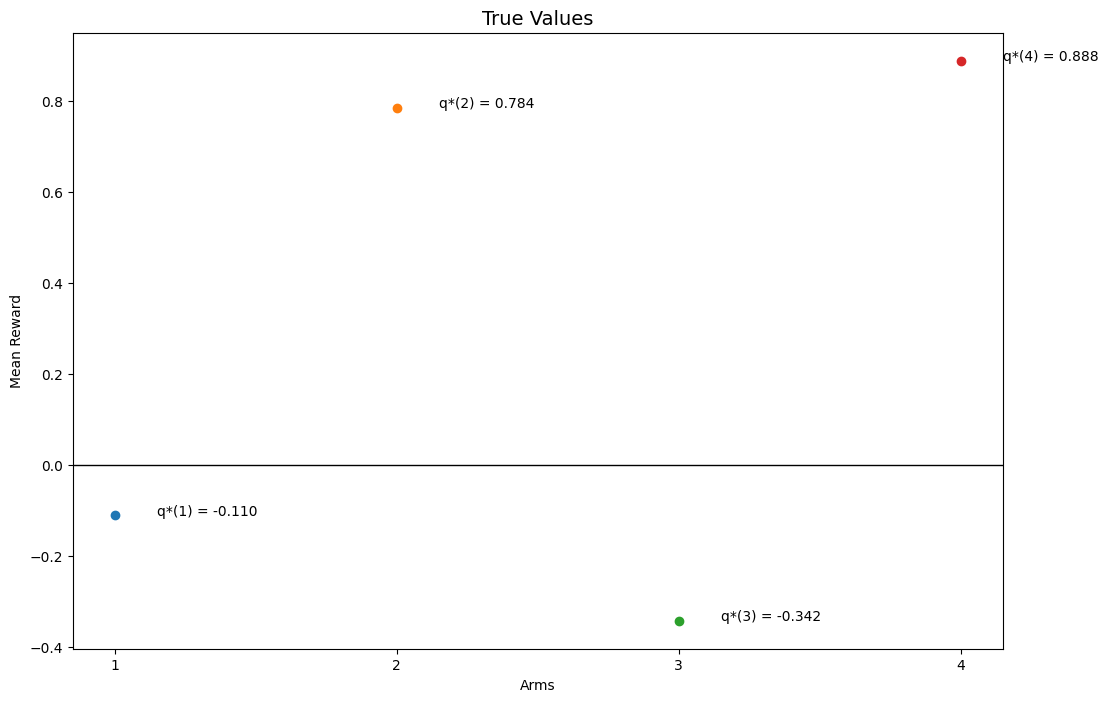

In [2]:
# Create and Show env
env = Testbed(k=4, num_problems=1000, stationary=False)
env.show_mean()


## eGreedy

100%|██████████| 1/1 [00:00<00:00, 167.36it/s]

Showing the following test: 
	Model name: eGreedy
	Action selection: simple_max
	Number of arms: 4
	Epsilon: 0.1
	Step-size/Learning rate (alpha): 1/n
	Steps: 500
	Initial Q: 1
	Average Reward: 1.323858983018166


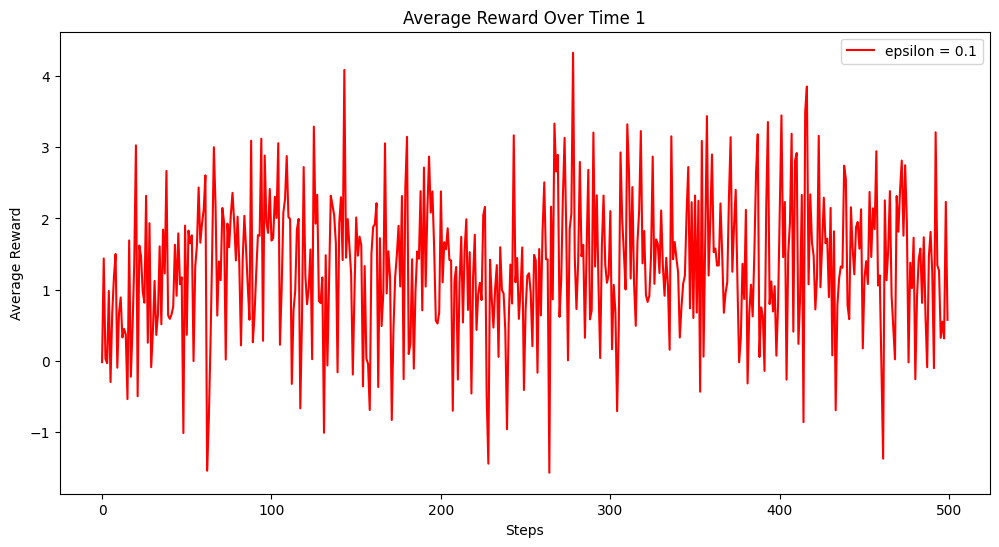

Testbed Means: [-0.97433653  0.92725548 -0.08186426 -0.48078879]


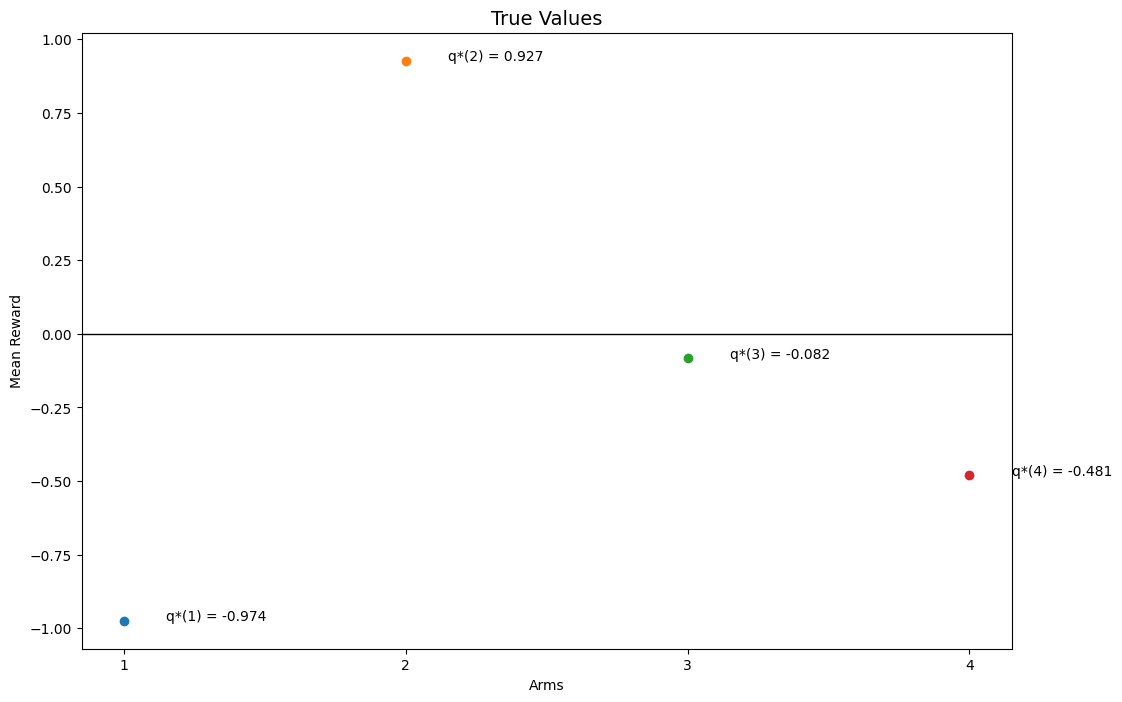

In [3]:
#Model Params
start_val = 1


# Create eGreedy task
# eg_01 = create_bandit_task(model_type="EG", model_params=[0,0.1], steps=trial_params, reward_values=reward_values, start_val=start_val)
eg_01 = create_bandit_task(model_type="EG", env=env, model_params=[0,0.1], steps=500, start_val=start_val )

tasks = [ eg_01]
for task in tasks:
    task.simulate(num_problems=1)
    task.show_results()
    # task.show_actions()

env.show_mean()


## Softmax

100%|██████████| 30/30 [00:00<00:00, 250.34it/s]


Showing the following test: 
	Model name: Softmax
	Action selection: Softmax | temperature = 10
	Number of arms: 4
	Learning rate: 0.6
	Steps: 500
	Initial Q: 1
	Average reward: 0.9634636006038042


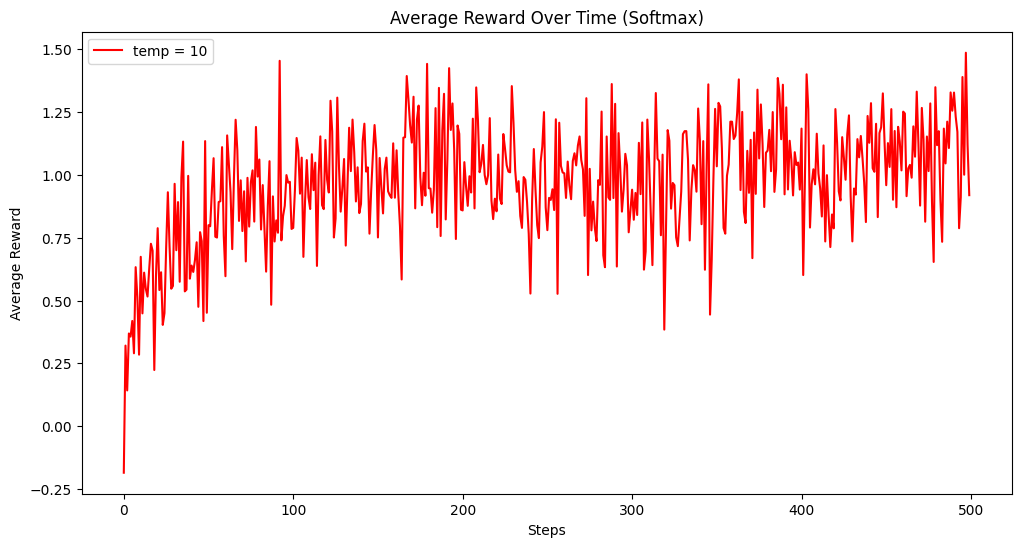

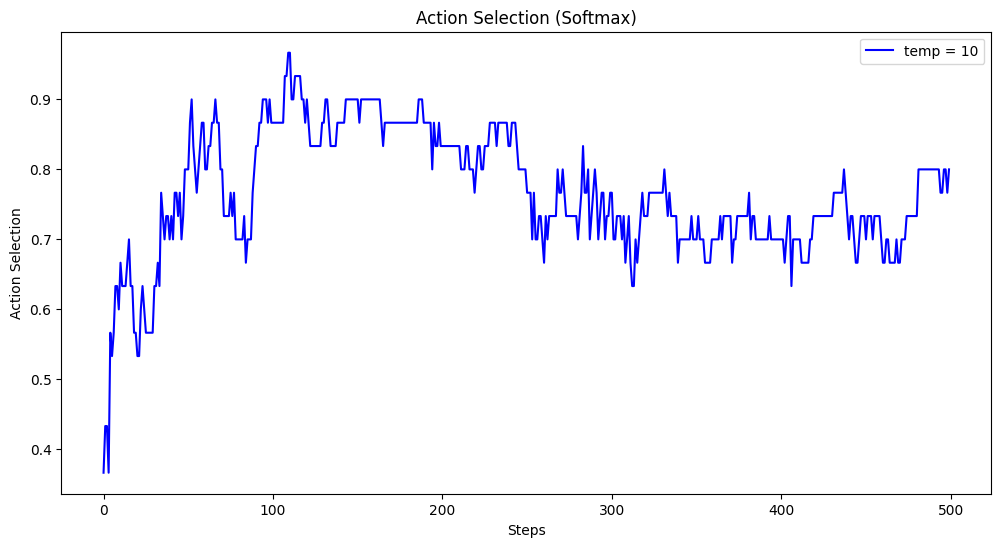

In [4]:
#Model Params
model_type = "SM"
alpha = 0.6
temp = 10                       # inverse temp
model_params = [alpha, temp]
# start_val = 1

SM = create_bandit_task(model_type, env.new(), model_params, steps=500, start_val=start_val)
SM.simulate(num_problems=30)
SM.show_results()
SM.show_actions()

## Softmax + Upper Confidence Bound

In [5]:
# Model Params
model_type = "SMUCB"
alpha = 0.1
temp = 10
uncertParam = .2
#uncert = 2
model_params = [alpha, temp, uncertParam]
# start_val = 1

SMUCB = create_bandit_task(model_type=model_type, env=env.new(), model_params=model_params, steps=500, start_val=start_val)

SMUCB.simulate(num_problems=1)

100%|██████████| 1/1 [00:00<00:00, 69.22it/s]


## Volatile Kalman Filter

Testbed Means: [-0.12353979 -0.90117609 -0.73071333 -1.87125788]


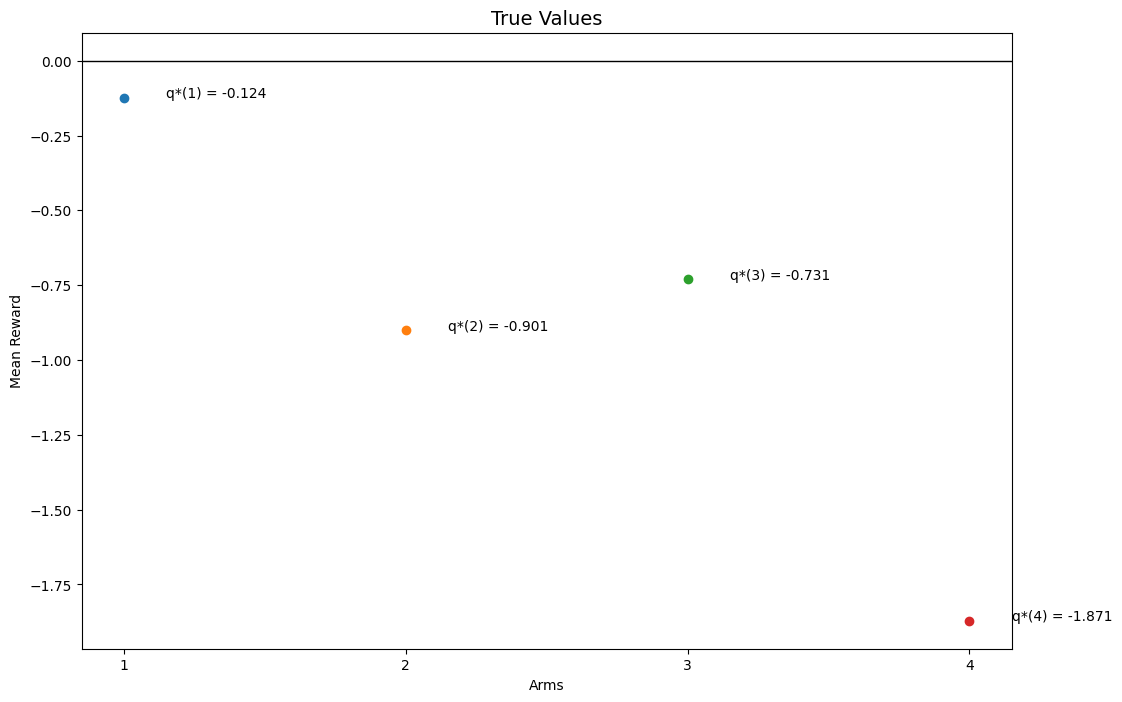

100%|██████████| 1/1 [00:00<00:00, 188.20it/s]

Showing the following test: 
	Model name: Volatile Kalman Filter
	Action selection: Volatile Kalman Filter | temp = 5
	Number of arms: 4
	Steps: 500
	Average reward: 0.015805425448120615


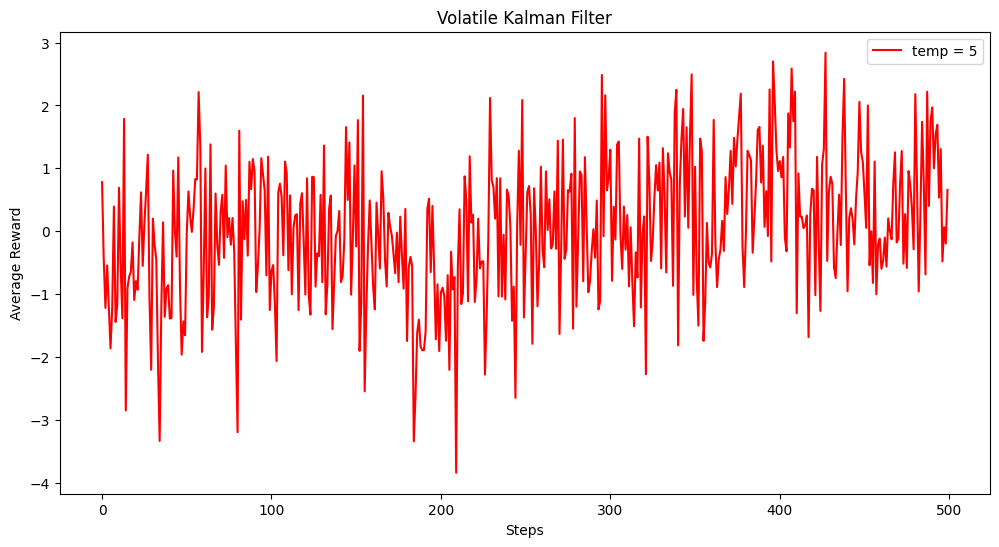

Testbed Means: [-0.92253906 -0.2096178   0.19268242 -1.23165442]


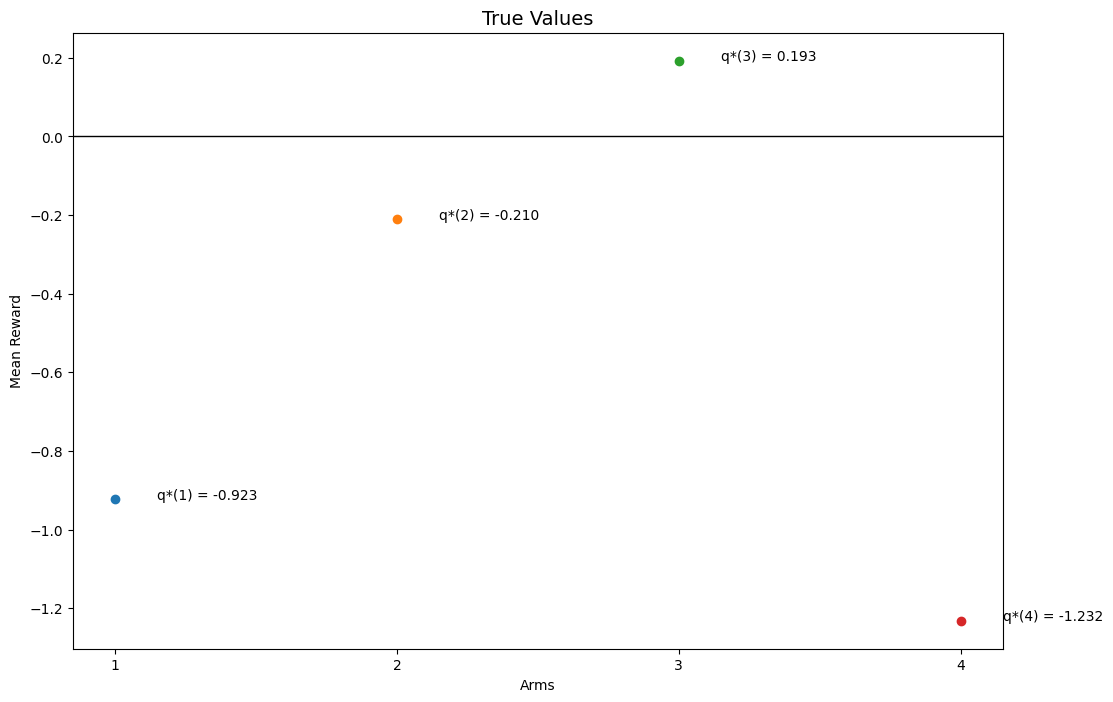

In [6]:
# Model Params
model_type = "VKF"                  
volatility_update_param = 0.6      # lamda
obervation_noise = 1              # Constant varience 
inital_volatility = 50             # Sigma
initial_posterior_mean = 0
initial_posterior_var = 10
temp = 5
start_val = 5

VKF = create_bandit_task(model_type=model_type, env=env.new(), model_params=[obervation_noise, volatility_update_param, inital_volatility, initial_posterior_mean, initial_posterior_var, temp], steps=500, start_val=start_val)

VKF.env.show_mean()
VKF.simulate(num_problems=1)

VKF.show_results()
VKF.env.show_mean()
 
# VKF.show_actions()

Plotting the following parameters:
number of parameters:
 79


100%|██████████| 79/79 [00:00<00:00, 236.52it/s]

[40.22692575 37.9704135  36.04216134 34.38532266 32.95426695 31.71216479
 30.62912673 29.68076325 28.84706555 28.11153179 27.46048168 26.88251638
 26.36809075 25.90917313 25.49897332 25.1317242  24.80250554 24.50710125
 24.24188323 24.00371642 23.78988088 23.59800757 23.42602526 23.27211639
 23.13468029 23.01230241 22.90372849 22.80784275 22.7236495  22.65025749
 22.58686663 22.53275662 22.48727723 22.44983991 22.41991062 22.39700359
 22.3806759  22.37052281 22.36617366 22.3672883  22.37355394 22.38468241
 22.40040772 22.42048395 22.44468331 22.47279449 22.50462115 22.53998057
 22.57870251 22.62062808 22.66560882 22.71350583 22.76418901 22.81753632
 22.87343321 22.93177196 22.99245126 23.05537565 23.12045516 23.18760485
 23.2567445  23.32779828 23.40069441 23.47536494 23.55174544 23.6297748
 23.70939501 23.79055098 23.8731903  23.95726314 24.04272204 24.12952179
 24.21761931 24.30697348 24.39754507 24.48929659 24.58219224 24.67619777
 24.77128041]
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2

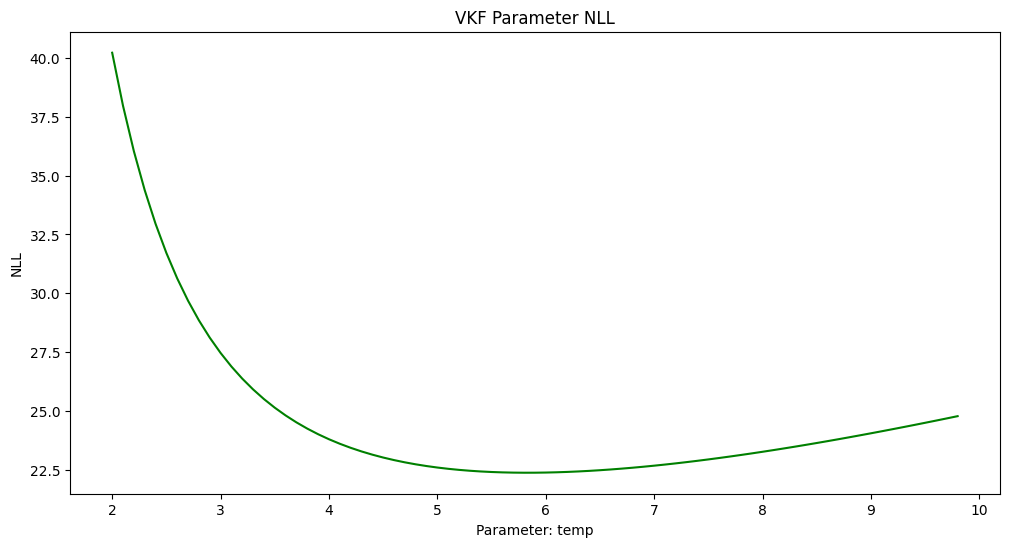

In [7]:
# print("using model params")
# VKF.LL_VKF(volatility_update_param, inital_volatility, temp) # using same parameters
# print("using completely different key parameters")
# VKF.LL_VKF(0.9,0.1, 0.3) #
# print(VKF.vary_param_NLL("temp", [0.01, 0.99, 0.01], v_update= volatility_update_param, v_init= inital_volatility, temp = None))

VKF.plot_parameter_likelihood("temp", [2, 10, 0.1], v_update= volatility_update_param, v_init= inital_volatility, temp = None)

Plotting the following parameters:
number of parameters:
 195


100%|██████████| 195/195 [00:00<00:00, 226.26it/s]

[22.39556465 22.38238267 22.40419755 22.44115905 22.48088155 22.51759888
 22.54934374 22.57593132 22.59786393 22.61582135 22.63045805 22.64234103
 22.65194346 22.65965631 22.66580274 22.67065087 22.67442383 22.67730759
 22.67945715 22.68100157 22.68204805 22.6826855  22.68298745 22.68301467
 22.68281728 22.6824366  22.68190674 22.68125584 22.68050717 22.67968003
 22.67879044 22.67785175 22.67687509 22.6758698  22.67484371 22.67380336
 22.67275426 22.67170102 22.67064747 22.66959678 22.66855154 22.66751383
 22.66648532 22.66546723 22.66446049 22.66346569 22.66248315 22.66151294
 22.66055493 22.65960879 22.65867403 22.65775002 22.656836   22.65593111
 22.65503441 22.65414489 22.65326149 22.65238309 22.65150859 22.65063684
 22.64976671 22.64889706 22.64802678 22.6471548  22.64628006 22.64540157
 22.64451835 22.64362949 22.64273415 22.64183153 22.6409209  22.64000157
 22.63907295 22.6381345  22.63718575 22.63622627 22.63525574 22.63427386
 22.63328043 22.63227529 22.63125834 22.63022956 22

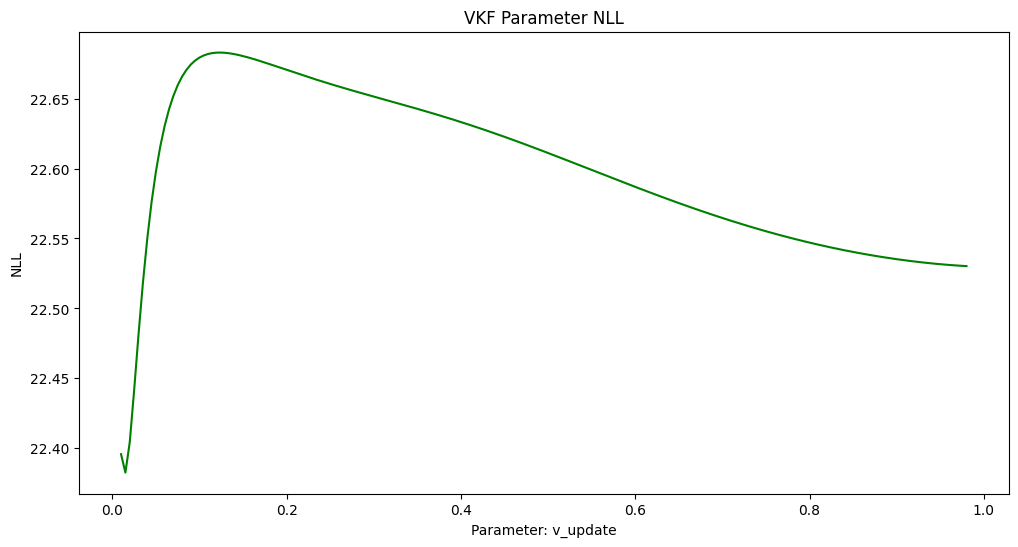

In [8]:
VKF.plot_parameter_likelihood("v_update", [0.01, 0.99, 0.005], v_update= None, v_init= inital_volatility, temp = temp)

Plotting the following parameters:
number of parameters:
 198


100%|██████████| 198/198 [00:00<00:00, 226.75it/s]


[22.58510607 22.58468009 22.58428759 22.58392537 22.5835907  22.58328122
 22.58299489 22.5827299  22.58248469 22.58225785 22.58204815 22.58185446
 22.58167578 22.58151121 22.58135993 22.58122119 22.58109429 22.58097863
 22.58087361 22.5807787  22.58069341 22.58061729 22.58054989 22.58049084
 22.58043975 22.58039628 22.5803601  22.5803309  22.5803084  22.58029232
 22.58028241 22.58027842 22.58028012 22.5802873  22.58029974 22.58031725
 22.58033965 22.58036674 22.58039837 22.58043437 22.58047459 22.58051887
 22.58056708 22.58061908 22.58067474 22.58073394 22.58079655 22.58086246
 22.58093157 22.58100376 22.58107893 22.58115699 22.58123785 22.5813214
 22.58140757 22.58149627 22.58158742 22.58168093 22.58177675 22.58187479
 22.58197497 22.58207725 22.58218154 22.58228779 22.58239593 22.5825059
 22.58261765 22.58273113 22.58284627 22.58296303 22.58308136 22.5832012
 22.58332251 22.58344524 22.58356936 22.58369481 22.58382155 22.58394955
 22.58407876 22.58420915 22.58434068 22.58447331 22.58

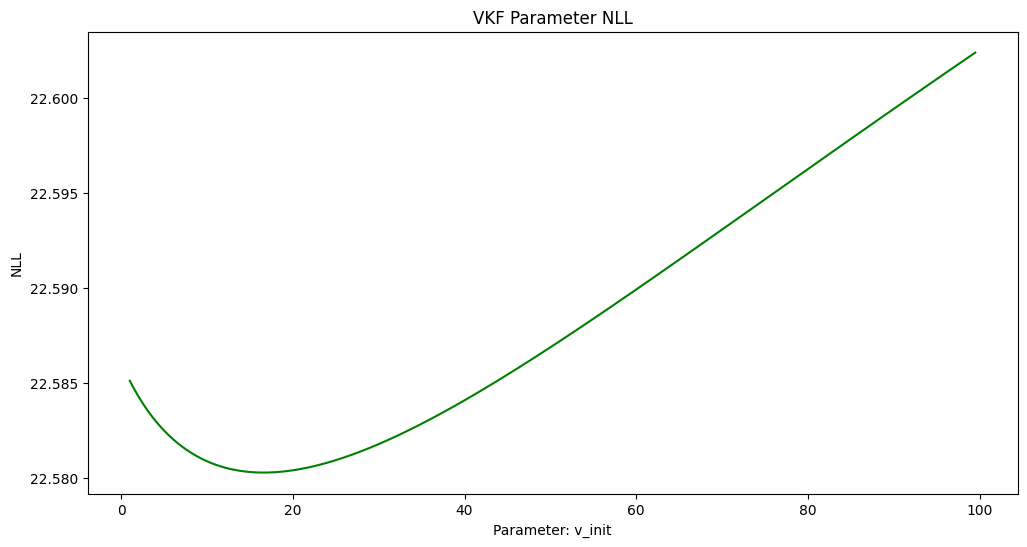

In [9]:
VKF.plot_parameter_likelihood("v_init", [1, 100, 0.5], v_update= volatility_update_param, v_init= None, temp = temp)

### Simulate Performance

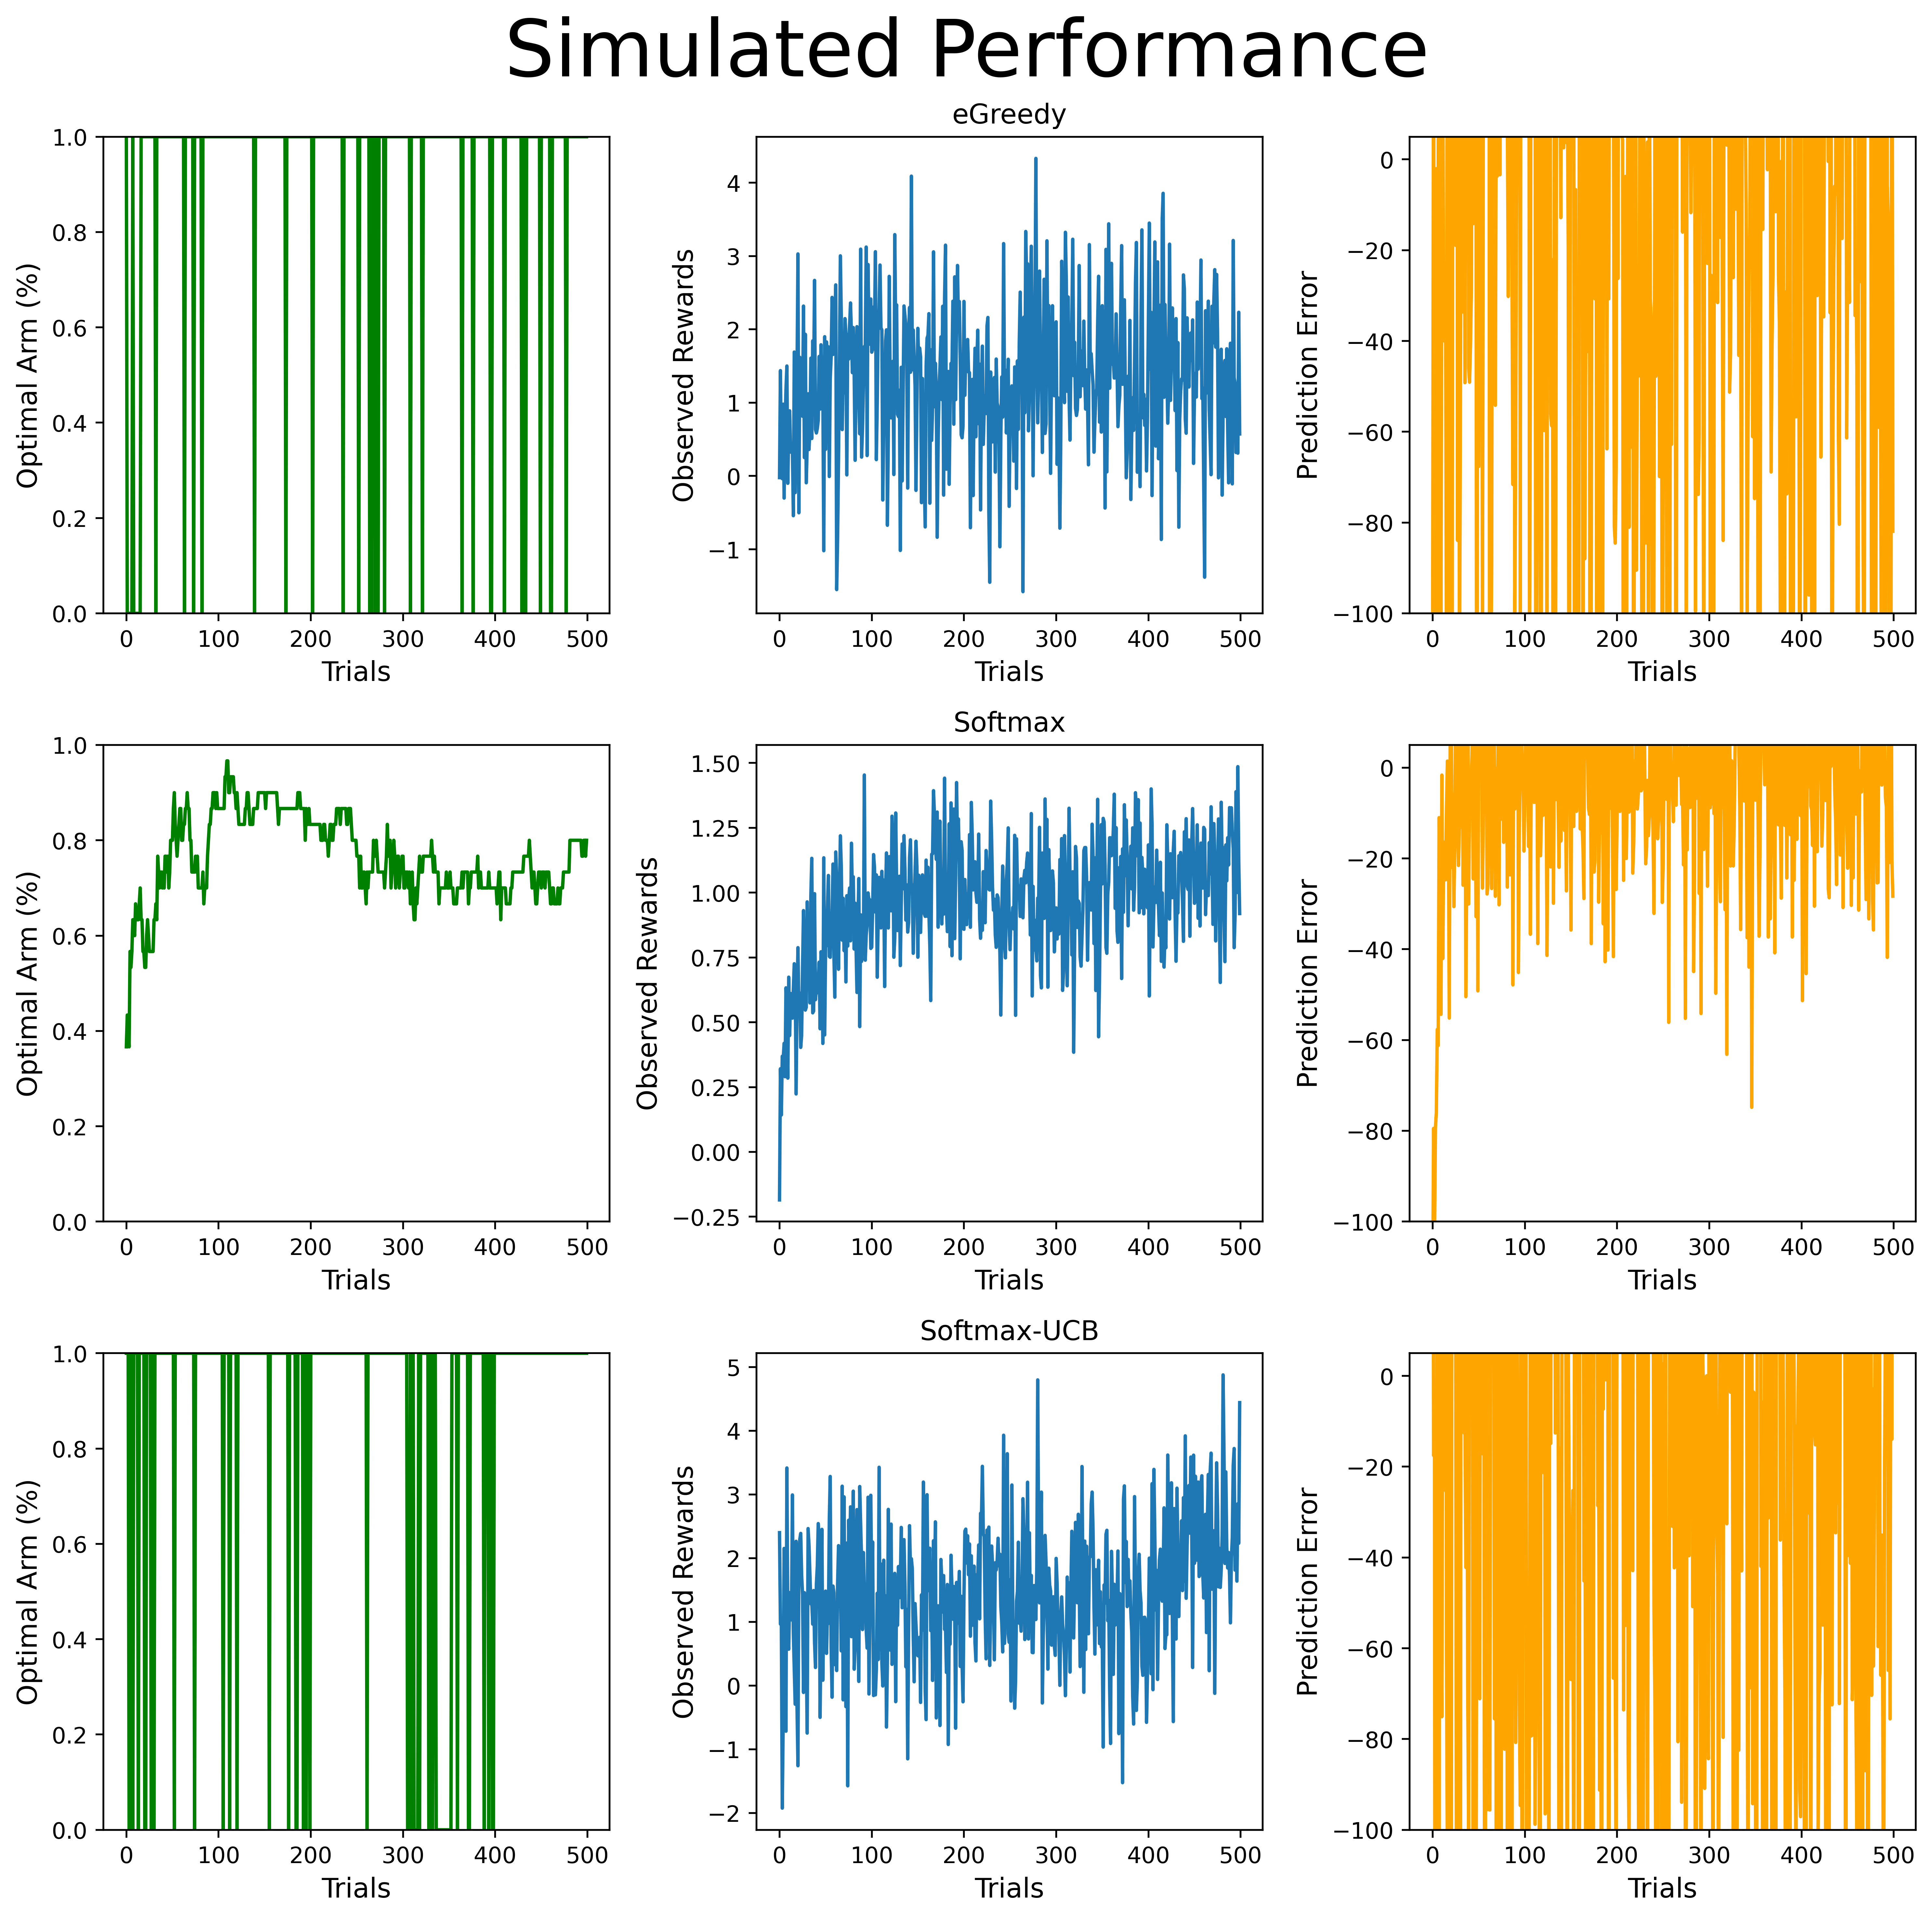

In [10]:
model_performance_summary(bandits=[eg_01, SM, SMUCB])
# print(f"Param Name:{key}\n {value}" for key, value in vars(eg_01))
# env.show_mean()

## Log-Likelihood

In [11]:
eg_01.simulate_LL(num_problems=500)
# SM.simulate_LL()
# SMUCB.simulate_LL()
# print(SMUCB.selection_matrix)

# print(eg_01.total_LL_array)
# print(SM.total_LL_array)
# print(SMUCB.total_LL_array)

  0%|          | 1/500 [00:00<00:00, 951.52it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
print(eg_01.total_LL_array)
plt.plot(eg_01.total_LL_array)

## Model Validation

#### Param Recovery
Fit data to model it was simulated with
<ol>
<li>Simulate choices and rewards using chosen parameter values(acts as ground truth)</li>
<li>
Run fitting procedure (neg log likelihood function) on simulated choice AND reward data.
See if we an estimate simulated parameter values (estimates are fitted parameter values)
</li>
</ol>

In [ ]:
# Run this to display mermaid flowchart of parameter recovery
mm("""
flowchart LR
   subgraph input-parameters
   direction TB
   id1([epsilon])
   id2([alpha])
   id3([etc...])
   id1 ~~~ id2 ~~~ id3
   end

   subgraph output-parameters
   direction TB
   id4([epsilon])
   id5([alpha])
   id6([etc...])
   id4 ~~~ id5 ~~~ id6
   end

   simData[(Simulated Data)]
   model((RL Model))
   n([noise])
   fm{{fit data to model}}

   input-parameters --"(1) input"--> model
   model --"(1) creates"--> simData
   simData -."(2) (optional) Add".-> n
   simData --> fm
   n -.-> fm
   fm ~~~ output-parameters
   fm --"(3) Outputs"--> output-parameters
   input-parameters o-- "(4) compare"  --o output-parameters

""")

#### Model Recovery

Fit data to all models
<ol>
<li>
Use simulated choice and reward data from paramater recovery step
</li>

<li>
Calculate negative log likelihood values using each model on the simulated data
</li>
</ol>
